# iperf3によるVM間の転送性能テスト

## Kubernets POD 編

### テストサーバーVMのアプリ実行状態を確認

In [1]:
!kubectl get pods -o wide -l app=iperf3

NAME                           READY     STATUS    RESTARTS   AGE       IP            NODE
iperf3-dep1-7bb5958b8d-vjg6n   1/1       Running   0          1d        172.17.0.6    minikube
iperf3-dep2-64b64896fb-msrxt   1/1       Running   0          1d        172.17.0.4    minikube
iperf3-dep3-77548cdbb4-2xcw7   1/1       Running   0          1d        172.17.0.7    minikube
iperf3-dep4-6f4686dbcb-lj2g5   1/1       Running   0          1d        172.17.0.5    minikube
iperf3-dep5-f4d69dc64-gdgtm    1/1       Running   0          1d        172.17.0.9    minikube
iperf3-dep6-6c9d6888dd-5ndcr   1/1       Running   0          1d        172.17.0.8    minikube
iperf3-dep7-878c5fc8d-gfflp    1/1       Running   0          1d        172.17.0.10   minikube
iperf3-dep8-754d7544bd-qfql8   1/1       Running   0          1d        172.17.0.11   minikube


### 同一の k8s namespace 内の4つのVM間でTCPスループットを計測(60秒)

Testing, wait 60 seconds...  done
/Users/ynakaoku/minikube-apps/advlabtools/tester/jupyter/reports/k8s-4peers-iperf3-190106-004409/k8s-4peers-cl-iperf3-dep8-754d7544bd-qfql8.json
[Avg BW(Gb) ]: 0.998463
[Retransmits]: 8
[Sndr CPU%  ]: 5.04411
[Rcvr CPU%  ]: 1.21978
/Users/ynakaoku/minikube-apps/advlabtools/tester/jupyter/reports/k8s-4peers-iperf3-190106-004409/k8s-4peers-cl-iperf3-dep5-f4d69dc64-gdgtm.json
[Avg BW(Gb) ]: 0.998413
[Retransmits]: 1798
[Sndr CPU%  ]: 3.89251
[Rcvr CPU%  ]: 0.963567
/Users/ynakaoku/minikube-apps/advlabtools/tester/jupyter/reports/k8s-4peers-iperf3-190106-004409/k8s-4peers-cl-iperf3-dep6-6c9d6888dd-5ndcr.json
[Avg BW(Gb) ]: 0.998416
[Retransmits]: 46
[Sndr CPU%  ]: 3.73369
[Rcvr CPU%  ]: 0.943771
/Users/ynakaoku/minikube-apps/advlabtools/tester/jupyter/reports/k8s-4peers-iperf3-190106-004409/k8s-4peers-cl-iperf3-dep7-878c5fc8d-gfflp.json
[Avg BW(Gb) ]: 0.998483
[Retransmits]: 3
[Sndr CPU%  ]: 4.20032
[Rcvr CPU%  ]: 0.955732


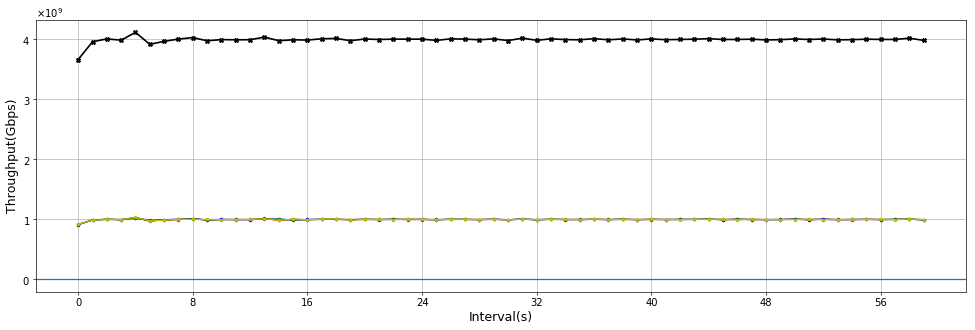

In [5]:
%run -i k8s_iperf3_peer.py -C k8s-4peers-config -N k8s-4peers -t 60 -b 1G

### NSX ESGを介した4つのVM間でTCPスループットを計測(60秒)

Testing, wait 60 seconds...  done
/root/mytesttools/tester/jupyter/reports/ESG4-iperf3-180319-191142/ESG4-cl-172.16.130.203.json


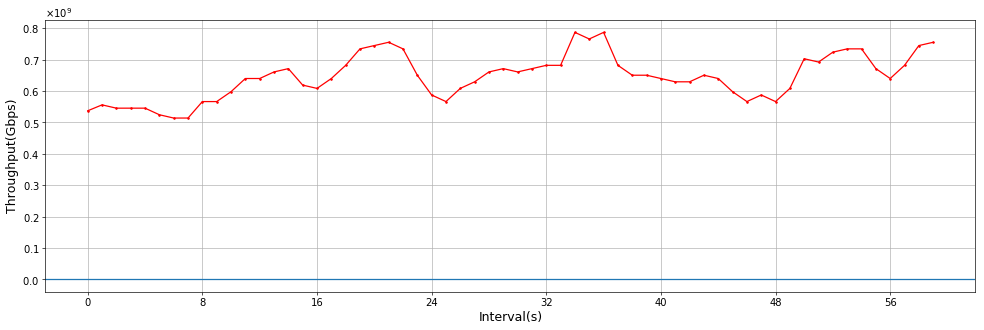

/root/mytesttools/tester/jupyter/reports/ESG4-iperf3-180319-191142/ESG4-cl-172.16.130.204.json


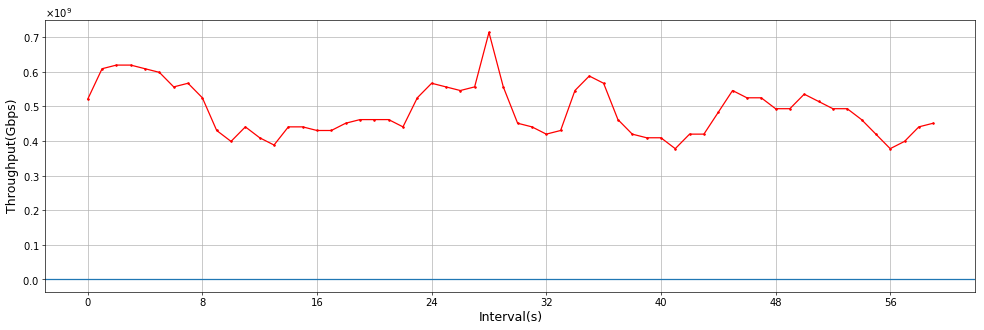

/root/mytesttools/tester/jupyter/reports/ESG4-iperf3-180319-191142/ESG4-cl-172.16.130.201.json


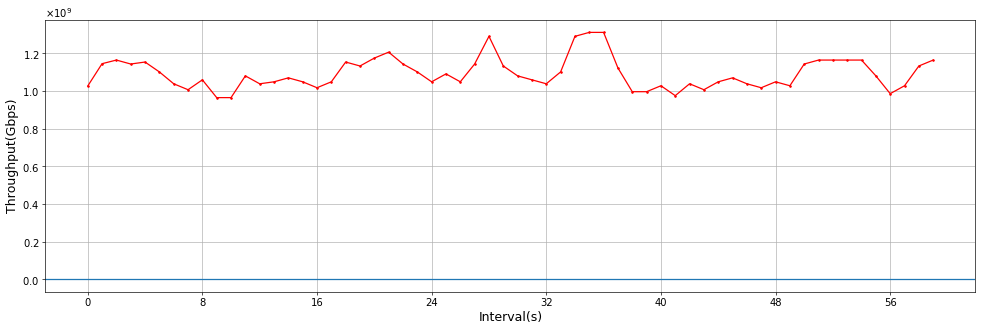

/root/mytesttools/tester/jupyter/reports/ESG4-iperf3-180319-191142/ESG4-cl-172.16.130.202.json


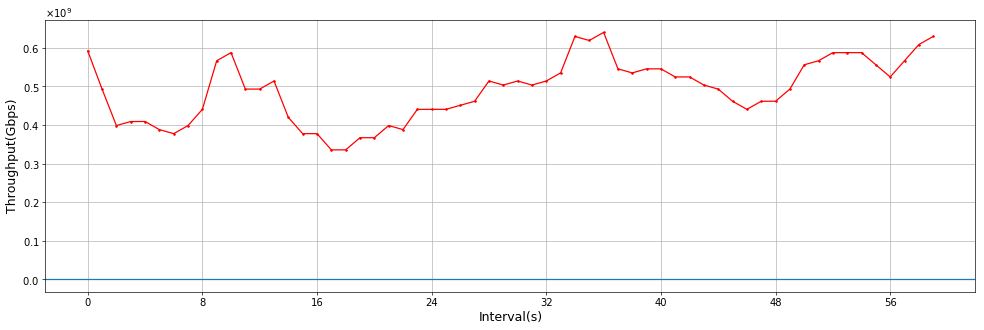

In [18]:
%run -i iperf3_peer.py -C ESG4-config -N ESG4 -t 60

### テスト用Pythonスクリプトを直接編集してテストをカスタマイズ

Testing, wait 10 seconds...  done
/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.202.json


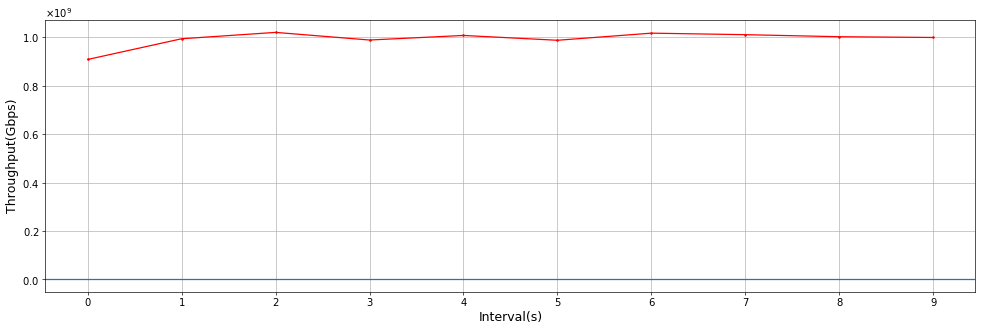

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.201.json


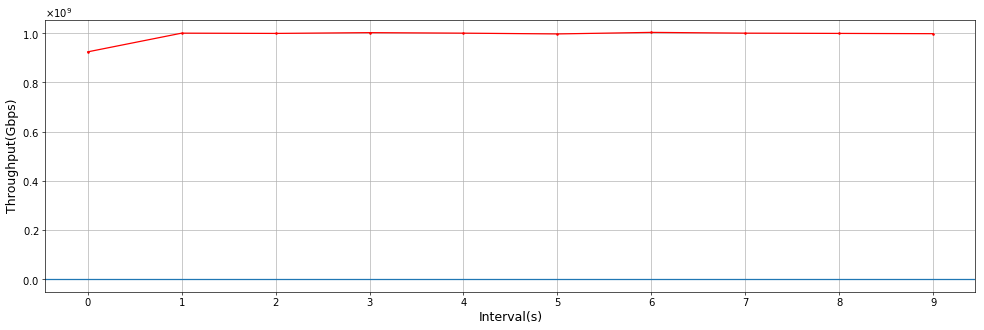

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.204.json


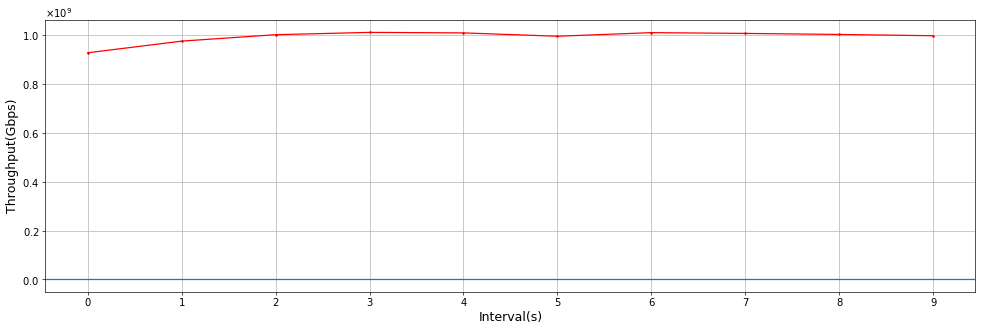

/root/mytesttools/tester/jupyter/reports/mytest01-iperf3-180328-194704/mytest01-cl-172.16.130.203.json


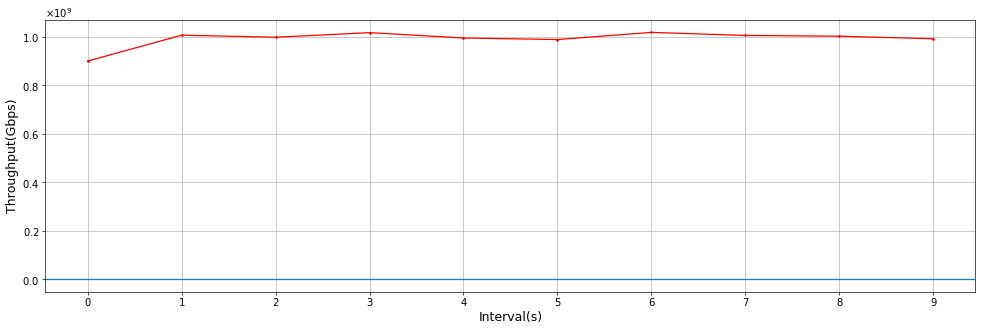

In [27]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import subprocess
import json
import glob

class FixedOrderFormatter(ticker.ScalarFormatter):
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=True):
        self._order_of_mag = order_of_mag
        ticker.ScalarFormatter.__init__(self, useOffset=useOffset,
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        self.orderOfMagnitude = self._order_of_mag

ConfigFile='DLS4-config'
TestName='mytest01'
Interval='1'
Bandwidth='1G'
Time='10'
Udp=False

def set_option():
    options = " -C " + ConfigFile + " -N " + TestName + " -J -s "
    if Interval:
        options = options + " -i " + Interval
    if Bandwidth:
        options = options + " -b " + Bandwidth
    if Time:
        options = options + " -t " + Time
    if Udp:
        options = options + " -u "

    return options

def init_plt():
    plt.figure(num=None, figsize=(20, 6), dpi=60, facecolor='w', edgecolor='k')
    plt.rcParams["font.size"] = 15
    plt.rcParams["xtick.labelsize"] = 12
    plt.rcParams["ytick.labelsize"] = 12
    plt.rcParams["legend.fontsize"] = 12
    plt.grid()
    plt.axhline(y=0)
    plt.xlabel("Interval(s)")
    plt.ylabel(u"Throughput(Gbps)")
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(9, useOffset=False))
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

def main():
    cmd = "../scripts/run_iperf3_peer.bash "
    cmd_options = set_option()

    print 'Testing, wait {} seconds... '.format(Time),
    dirname = str(subprocess.check_output( cmd+cmd_options, shell=True, universal_newlines=True )).replace('\n','')
    print 'done'

    json_files = glob.glob(dirname + "/*cl*.json")

    for file in json_files:
        print(file)
        f = open(file, 'r')
        perf_dict = json.load(f)

        init_plt()

        x = np.array(range(len(perf_dict["intervals"])))
        y = np.array([])

        for p in perf_dict["intervals"]:
            y = np.append(y, p["sum"]["bits_per_second"])

        plt.plot(x, y, "r",marker="o",markersize=2)

        plt.show()

# Start program
if __name__ == "__main__":
    main()